# Introduction to Sparsity III: Deconvolution

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
 * [Objective](#Objective)
 * [Point Spread Function](#Point-Spread-Function)
1. [Deconvolution Example](#Deconvolution-Example)
 * [Convolution](#Convolution)
 * [Deconvolution](#Deconvolution)
 * [Convolution with Noise](#Convolution-with-Noise)
 * [Deconvolution with Noise](#Deconvolution-with-Noise)
1. [Ill-Posed Problem](#Ill-Posed-Problem)
 * [Ill-Conditioned Problem](#Ill-Conditioned-Problem)
1. [Deconvolution Exercise](#Deconvolution-Exercise)
 * [Deconvolution with Sparsity](#Deconvolution-with-Sparsity)

---

## Set-Up

Here we will import a couple of packages that we be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np

# Import tools from Scipy
from scipy.ndimage import gaussian_filter
from scipy.misc import face

# Import function to set size of figures.
from matplotlib.pylab import rcParams

# Import interaction module.
from ipywidgets.widgets import *

# Import tutorial functions.
from sparsity_tutorial import plot
from sparsity_tutorial.functions import *

In [2]:
# Set size of figures.
rcParams['figure.figsize'] = (14.0, 8.0)

---

## Introduction

### <font color='blue'>Objective</font>

The objective of this notebook is to demonstrate how sparsity can be used for deconvolution. A very simple image is used to simpify the implementation. More realistic applications to astrophysical images are provided in

* <a href="https://www.aanda.org/articles/aa/abs/2017/05/aa29709-16/aa29709-16.html" target_="blank">Farrens et al. (2017)</a>

### <font color='blue'>Point Spread Function</font>

All optical systems are subject to imperfections that distort the images obtained. The sum of these aberrations is commonly referred to as the point spread function (PSF) or instrumental response. Removing the effects of the PSF from images of interest if a fundamental aspect of image processing, particularly in fields such as astrophysics where accurate measurments of the shapes and flux of objects has a significant impact on the science.

The blurring introduced by the PSF can be modelled as a convolution of the PSF with the image. Consequently, the reverse process, deconvolution, removes this effect.

In the following cell we define a function for generating a Gaussian PSF.

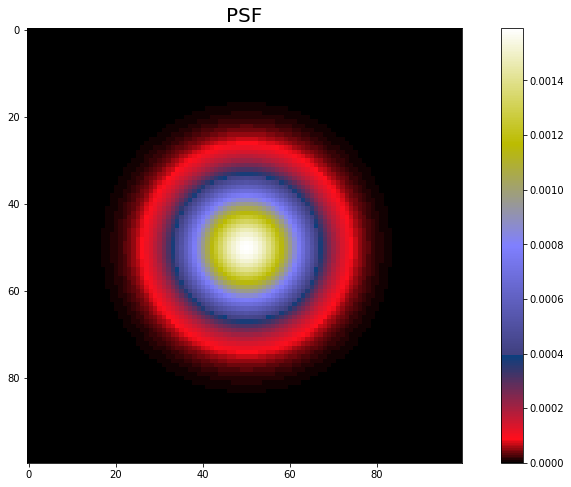

In [3]:
# Function to generate a Gaussian PSF.
def make_psf(shape, sigma):
    
    psf = np.zeros(shape)
    psf[list(zip(np.array(psf.shape) // 2))] = 1
    
    return gaussian_filter(psf, sigma)

plot.display(make_psf((100, 100), 10), title='PSF')

## Deconvolution Example

### <font color='blue'>Convolution</font>

The <a href="https://en.wikipedia.org/wiki/Convolution_theorem" target_="blank">convolution theorem</a> shows that a signal $a$ can be convolved with a signal $b$ (under certain conditions) as follows

$$c = a * b = \mathcal{F}^{-1}(\mathcal{F}(a) \cdot \mathcal{F}(b))$$

We can implement this as follows.

In [4]:
# This function convolves an image with a kernel using FFT.
def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

The following cell demonstrates what happens to an image when it is convolved with the PSF we defined.

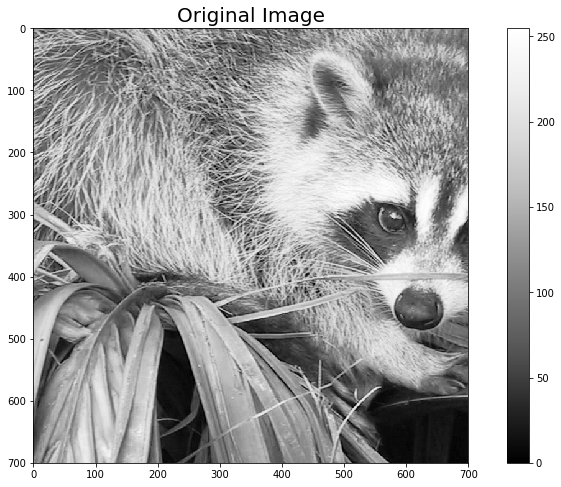

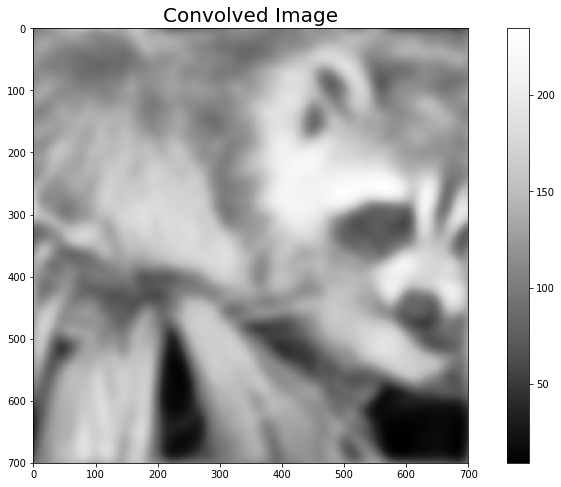

In [5]:
# Load example image
image = face()[:700, :700, 0]

# Generate a PSF
psf_1 = make_psf(image.shape, 10)

# Convolve image with PSF
image_conv = fftconvolve(image, psf_1)

# Display the original image
plot.display(image, cmap='Greys_r', title='Original Image')

# Display the convolved image
plot.display(image_conv, cmap='Greys_r', title='Convolved Image')

### <font color='blue'>Deconvolution</font>

<a href="https://en.wikipedia.org/wiki/Deconvolution" target_="blank">Deconvolution</a> is the process of reversing the effects of convolution.

$$a = \mathcal{F}^{-1}\bigg(\frac{\mathcal{F}(c)}{\mathcal{F}(b)}\bigg)$$

We can implement this process as follows.

In [6]:
# This function deconvolves an image with a kernel using FFT.
def fftdeconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x / y))))

Using this function we can recover our original image given that we know the PSF.

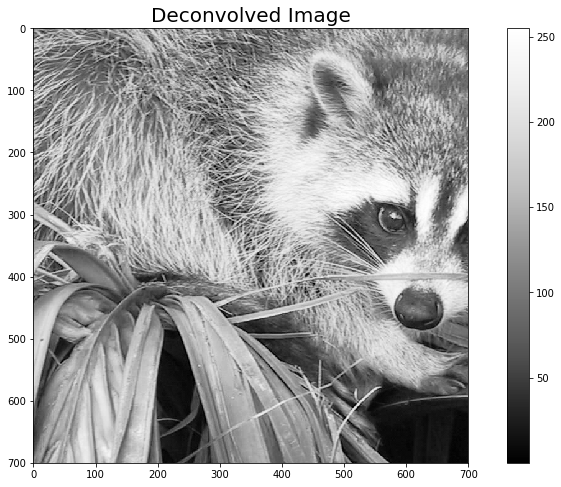

In [7]:
image_deconv = fftdeconvolve(image_conv, psf_1)

# Display the convolved image
plot.display(image_deconv, cmap='Greys_r', title='Deconvolved Image')

As you can see the all the blurring effects have been removed from the convolved image.

### <font color='blue'>Convolution with Noise</font>

In practical applications all observations contain some degree of noise. We can imagine that our Raccoon was photographed with a very good instrument with only the tiniest amount of noise ($\sigma=10^{-6}$) as follows.

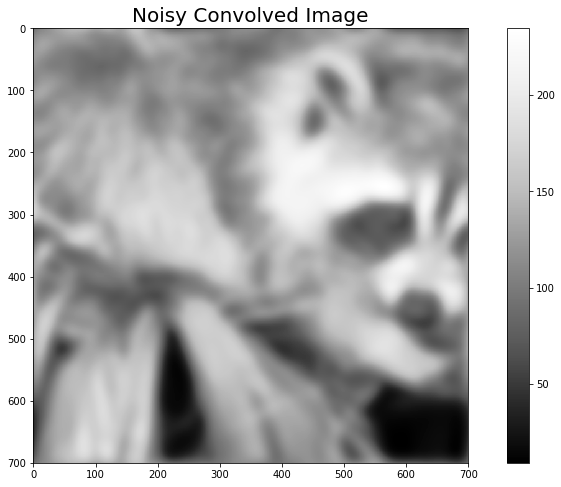

In [8]:
# Add Gaussian noise to convolved image
image_conv_noise = image_conv + np.random.randn(*image_conv.shape) * 1e-6

# Display the convolved image
plot.display(image_conv_noise, cmap='Greys_r', title='Noisy Convolved Image')

Given the amount of noise, the convolved image looks virtually the same.

### <font color='blue'>Deconvolution with Noise</font>

Let's see what happens when we try to recoever the original image from the noisy convolved image.

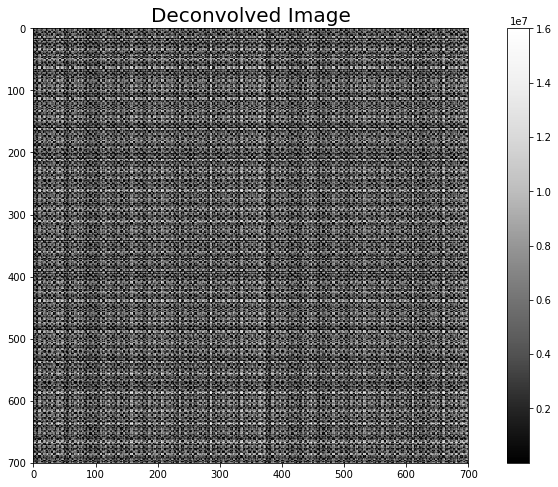

In [9]:
image_deconv_noise = fftdeconvolve(image_conv_noise, psf_1)

# Display the convolved image
plot.display(image_deconv_noise, cmap='Greys_r', title='Deconvolved Image')

The image is completely destroyed! Why?

---

## Ill-Posed Problem

A problem is considered <a href="https://en.wikipedia.org/wiki/Well-posed_problem" target_="blank">well-posed</a> if 

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

Any problem that does meet all three of this requirements is considered "ill-posed".

### <font color='blue'>Ill-Conditioned Problem</font>

A problem (or matrix) with a large <a href="https://en.wikipedia.org/wiki/Condition_number" target_="blank">condition number</a> is considered to be "ill-coniditioned". This relates to the 3rd point on our list of requirements for a well-posed problem.

Take for example the following two problems

$$\begin{bmatrix} 4 \\ 7 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 2 & 3 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$

$$\begin{bmatrix} 3 \\ 1.47 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 0.48 & 0.99 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$

Both are linear inverse problems of the form $y=Hx$, which can be implemented as follows.

In [10]:
# Data for first problem
y1 = np.array([4.0, 7.0])
H1 = np.array([[1.0, 2.0], [2.0, 3.0]])

# Data for second problem|
y2 = np.array([3.0, 1.47])
H2 = np.array([[1.0, 2.0], [0.48, 0.99]])

Two solve both problems we simply need to calculate $x = H^{-1}y$ as follows.

In [11]:
# Solution to the first problem
x1 = np.dot(np.linalg.inv(H1), y1)
print('x1 =', x1)

# Solution to the second problem
x2 = np.dot(np.linalg.inv(H2), y2)
print('x2 =', x2)

x1 = [ 2.  1.]
x2 = [ 1.  1.]


Now, let's see what happens if we add a small change to $y$ (e.g. mimicking the effects of noise).

$$\begin{bmatrix} 4 \\ 7.01 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 2 & 3 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$

$$\begin{bmatrix} 3 \\ 1.48 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 0.48 & 0.99 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$

In [12]:
# Noisy versions of y
y1_noise = np.array([4.0, 7.01])
y2_noise = np.array([3.0, 1.48])

x1_noise = np.dot(np.linalg.inv(H1), y1_noise)
print('x1 =', x1_noise)

x2_noise = np.dot(np.linalg.inv(H2), y2_noise)
print('x2 =', x2_noise)

x1 = [ 2.02  0.99]
x2 = [ 0.33333333  1.33333333]


Notice that for the first problem the solution has changed only as much as the input data, while for the second problem the solution is completely different. 

It is clear from these results that the first problem is well-conditioned well the second is ill-conditioned. This means that the first problem can be solved analytically, even with noise, well the second cannot.

We can relate this property back to our deconvolution problem, which can also be modelled as a linear inverse problem of the form

$$y=Hx + n$$

where $y$ is the noisy convolved image we observe, $H$ is a operator that represents convolution with the PSF, $x$ is the original image and $n$ is Gaussian random noise. As $H$ is ill-conditioned and hence the problem is ill-posed this cannot be solved analytically. This is where sparsity comes in!

---

## Deconvolution Exercise

### <font color='blue'>Deconvolution with Sparsity</font>

Given that we can model our observations as $y=Hx + n$, we aim to solve an optimisation problem of the form

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|y-H\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we assume we know that our data is sparse in the dictionary $\phi$. Notice that this is exactly the same problem we needed to solve for the CS exercises, only now $H$ is a convolution operator rather than a masking operator.

### <font color='blue'>Problem</font>

An observer with has obtained a very blurry and noisy image with instrument. Fortunately she is celever and knows the exact PSF of her instrument. She now provides you with her image and the PSF her instrument and asks for help in deconvoving the PSF effects.

You, being an expert in sparsity and having some experience with this type of data, know that this signal is sparse in Fourier space. You also know that $\lambda=0.003$ would be an appropriate value for this problem.

**Questions and tasks**
1. Try to deconvolve the image analytically.
1. Does it work?
1. What is the gradient of this problem?
1. What is the cost function of this problem?
1. Make a first guess for $x$.
1. Deconvolve the image using the Forward-Backward algorithm.
1. Display your deconvolved image $\hat{x}$.
1. Roughly how many iterations did it take to converge?
1. Finally, load the file `data/cs_true_data.npy` to determine the NMSE of your solution.

### <font color='blue'>Data</font>

For this exercise you are given a noisy convolved observation $y$ and a PSF. Your task is to deconvolve the psf effects from the observation to recover the original image $x$. 

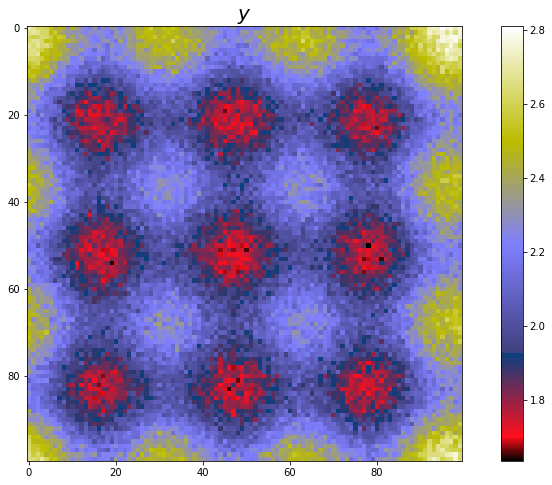

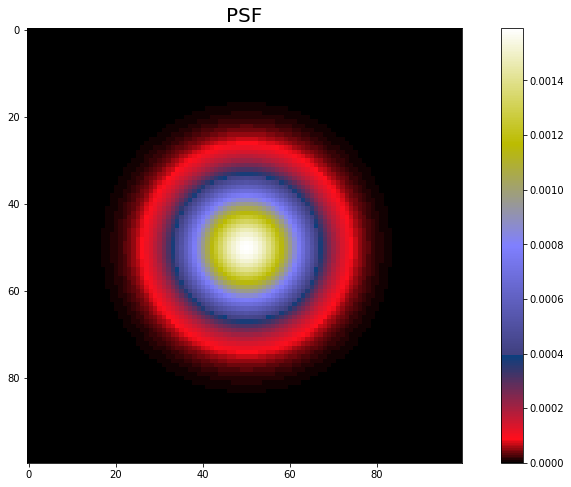

In [13]:
# Load the observation.
y = np.load('data/deconv_obs_data.npy')

# Load the PSF.
psf = np.load('data/deconv_psf.npy')

# Display the observed image.
plot.display(y, r'$y$')

# Display the PSF.
plot.display(psf, 'PSF')

### <font color='blue'>Functions</font>

Some functions that may be useful for this exercise are provided below.

In [14]:
# H operator.
def H(data, psf):
    
    return fftconvolve(data, psf)

# H transpose operator.
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))

# Function that performs simple forward backward splitting.
def forwardBackward(observation, first_guess, psf, grad, lambda_val, n_iter=300, gamma=1.0, return_cost=False):
    
    alpha_rec = first_guess
    cost = []
            
    for i in range(n_iter):
        
        alpha_temp = alpha_rec - gamma * grad(observation, alpha_rec, psf)
        alpha_rec = soft_thresh(alpha_temp, lambda_val)
        cost.append(cost_func(observation, alpha_rec, psf, lambda_val))
    
    if return_cost:
        return alpha_rec, cost
    else:
        return alpha_rec

### <font color='blue'>Solutions</font>

<font color='red'>EXERCISE:</font> provide your solutions in the cell(s) below.

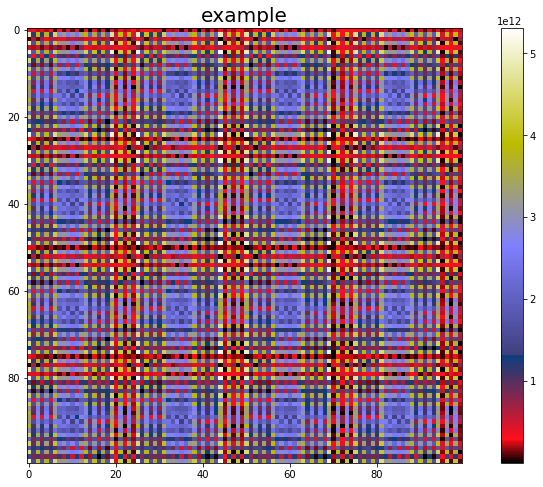

In [15]:
plot.display(fftdeconvolve(y, psf))

In [16]:
def grad(y, alpha_rec, psf):
    
    return ifft(Ht(H(fft(alpha_rec), psf) - y, psf))

In [17]:
def cost_func(y, alpha_rec, psf, lambda_):
    
    return (0.5 * np.linalg.norm(y - H(fft(alpha_rec), psf)) ** 2 + lambda_ * l1_norm(alpha_rec))

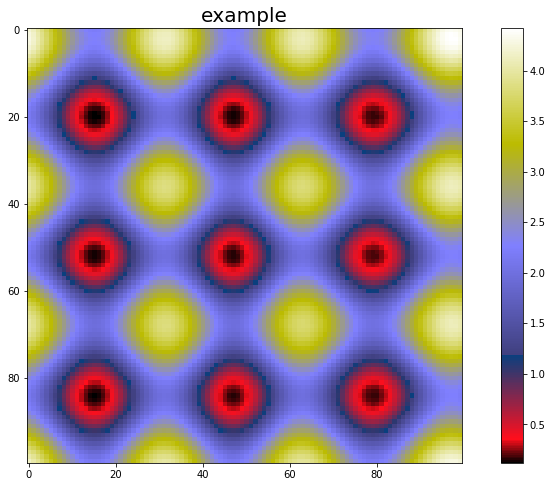

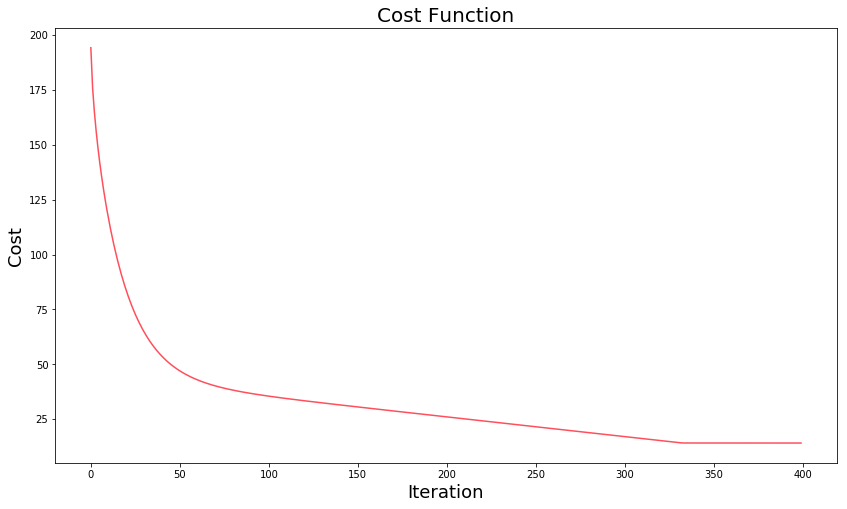

In [18]:
alpha_rec, cost = forwardBackward(y, np.ones(y.shape), psf, grad, lambda_val=0.003, n_iter=400, return_cost=True)

x_rec = fft(alpha_rec)

plot.display(x_rec)
plot.cost_plot(cost)

In [21]:
# Print the NMSE of the solution
print('NMSE =', nmse(np.load('data/cs_true_data.npy'), x_rec.flatten()))

NMSE = 0.00593340857313


---

## <font color='orange'>Hints</font>

** Deconvolution Exercise **

1. I wonder if the functions provided will help for defining the cost function and the gradient.
1. Make sure you display your deconvolved image in the correct domain.
1. If you plot your cost function it should be pretty easy to see when the algorithm converged.